In [2]:
# Assignment - 1
# https://coronavirus.jhu.edu/data/mortality

import os
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime

from pandasql import sqldf

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import minmax_scale

from scipy.stats import kurtosis, skew


In [3]:
df_raw = pd.read_csv("/Users/harini-mac/Desktop/Northwestern University/MSDS-422/Week1/Assignment1/covid_19.csv")
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43718 entries, 0 to 43717
Data columns (total 12 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   dateRep                                                     43718 non-null  object 
 1   day                                                         43718 non-null  int64  
 2   month                                                       43718 non-null  int64  
 3   year                                                        43718 non-null  int64  
 4   cases                                                       43718 non-null  int64  
 5   deaths                                                      43718 non-null  int64  
 6   countriesAndTerritories                                     43718 non-null  object 
 7   geoId                                                       43529 non-null  object 
 

In [4]:
df_raw.head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2019,continentExp,Cumulative_number_for_14_days_of_COVID-19_cases_per_100000
0,19/09/2020,19,9,2020,47,1,Afghanistan,AF,AFG,38041757.0,Asia,1.616645
1,18/09/2020,18,9,2020,0,0,Afghanistan,AF,AFG,38041757.0,Asia,1.535155
2,17/09/2020,17,9,2020,17,0,Afghanistan,AF,AFG,38041757.0,Asia,1.653446
3,16/09/2020,16,9,2020,40,10,Afghanistan,AF,AFG,38041757.0,Asia,1.708649
4,15/09/2020,15,9,2020,99,6,Afghanistan,AF,AFG,38041757.0,Asia,1.627159


In [5]:
# clean the data frame - remove NA values
df_cln= df_raw.dropna()
df_cln.shape

(40761, 12)

In [6]:
# Remove any records with cases, or deaths, or Cumulative_number_for_14_days_of_COVID-19_cases_per_100000 that are negative
# Change the Date from string to Datetime format
# Rename the Cumulative_number_for_14_days_of_COVID-19_cases_per_100000 to remove the hyphen
df_cln= df_cln[(df_cln['cases'] >= 0) & (df_cln['deaths'] >= 0) & (df_cln['Cumulative_number_for_14_days_of_COVID-19_cases_per_100000'] >= 0)]
df_cln['Date'] = pd.to_datetime(df_cln['dateRep'], format = '%d/%m/%Y')
df_cln=df_cln.rename(columns={"Cumulative_number_for_14_days_of_COVID-19_cases_per_100000": "Cumulative_number_for_14_days_of_COVID_19_cases_per_100000"})
df_cln.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40700 entries, 0 to 43704
Data columns (total 13 columns):
 #   Column                                                      Non-Null Count  Dtype         
---  ------                                                      --------------  -----         
 0   dateRep                                                     40700 non-null  object        
 1   day                                                         40700 non-null  int64         
 2   month                                                       40700 non-null  int64         
 3   year                                                        40700 non-null  int64         
 4   cases                                                       40700 non-null  int64         
 5   deaths                                                      40700 non-null  int64         
 6   countriesAndTerritories                                     40700 non-null  object        
 7   geoId                 

In [7]:
# Sort the data frame based on Date
df_cln = df_cln.sort_values(by="Date")
df= df_cln.drop(['dateRep', 'day','month','year'], axis=1)
df

,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2019,continentExp,Cumulative_number_for_14_days_of_COVID_19_cases_per_100000,Date
8822,0,0,China,CN,CHN,1.433784e+09,Asia,0.004115,2020-01-13
34525,0,0,San_Marino,SM,SMR,3.445300e+04,Europe,0.000000,2020-01-13
43026,0,0,Vietnam,VN,VNM,9.646211e+07,Asia,0.000000,2020-01-13
26861,0,0,Monaco,MC,MCO,3.308500e+04,Europe,0.000000,2020-01-13
240,0,0,Afghanistan,AF,AFG,3.804176e+07,Asia,0.000000,2020-01-13
...,...,...,...,...,...,...,...,...,...
35914,9,1,Sint_Maarten,SX,SXM,4.238900e+04,America,148.623464,2020-09-19
3939,0,0,Belgium,BE,BEL,1.145552e+07,Europe,102.125447,2020-09-19
19439,3049,144,Iran,IR,IRN,8.291389e+07,Asia,40.314112,2020-09-19
1441,12701,262,Argentina,AR,ARG,4.478068e+07,America,336.115970,2020-09-19


In [8]:
# Descriptive statistics on the numeric attributes
df.describe()

,cases,deaths,popData2019,Cumulative_number_for_14_days_of_COVID_19_cases_per_100000
count,40700.000000,40700.00000,4.070000e+04,40700.000000
mean,750.120123,23.34914,4.350121e+07,33.083606
std,4506.320642,129.21568,1.593253e+08,76.153225
min,0.000000,0.00000,8.150000e+02,0.000000
25%,0.000000,0.00000,1.355982e+06,0.378737
50%,13.000000,0.00000,8.519373e+06,4.582262
75%,179.000000,3.00000,2.916192e+07,26.518748
max,97894.000000,4928.00000,1.433784e+09,1058.225943


In [9]:
print('cases')
print( 'excess kurtosis of normal distribution (should be 0): {}'.format( kurtosis(df['cases']) ))
print( 'skewness of normal distribution (should be 0): {}'.format( skew(df['cases']) ))
print('\n')

print('deaths')
print( 'excess kurtosis of normal distribution (should be 0): {}'.format( kurtosis(df['deaths']) ))
print( 'skewness of normal distribution (should be 0): {}'.format( skew(df['deaths']) ))
print('\n')

print ('popData2019')
print( 'excess kurtosis of normal distribution (should be 0): {}'.format( kurtosis(df['popData2019']) ))
print( 'skewness of normal distribution (should be 0): {}'.format( skew(df['popData2019']) ))
print('\n')

print ('Cumulative_number_for_14_days_of_COVID_19_cases_per_100000')
print( 'excess kurtosis of normal distribution (should be 0): {}'.format( kurtosis(df['Cumulative_number_for_14_days_of_COVID_19_cases_per_100000']) ))
print( 'skewness of normal distribution (should be 0): {}'.format( skew(df['Cumulative_number_for_14_days_of_COVID_19_cases_per_100000']) ))
print('\n')

cases
excess kurtosis of normal distribution (should be 0): 170.62107877268303
skewness of normal distribution (should be 0): 12.005469335000846


deaths
excess kurtosis of normal distribution (should be 0): 200.59361641719707
skewness of normal distribution (should be 0): 11.373023477275021


popData2019
excess kurtosis of normal distribution (should be 0): 62.07280788011572
skewness of normal distribution (should be 0): 7.684406236692145


Cumulative_number_for_14_days_of_COVID_19_cases_per_100000
excess kurtosis of normal distribution (should be 0): 36.296192005540824
skewness of normal distribution (should be 0): 4.942448505046181




In [10]:
# Create a correlation plot

corr = df.corr()
corr.style.background_gradient(cmap='summer').set_precision(2)

,cases,deaths,popData2019,Cumulative_number_for_14_days_of_COVID_19_cases_per_100000
cases,1.00,0.75,0.35,0.22
deaths,0.75,1.00,0.25,0.20
popData2019,0.35,0.25,1.00,-0.04
Cumulative_number_for_14_days_of_COVID_19_cases_per_100000,0.22,0.20,-0.04,1.00


In [11]:
# Prepare the dataframe for time-series analysis 
ts = df.set_index(['Date'])
ts

,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2019,continentExp,Cumulative_number_for_14_days_of_COVID_19_cases_per_100000
Date,,,,,,,,
2020-01-13,0,0,China,CN,CHN,1.433784e+09,Asia,0.004115
2020-01-13,0,0,San_Marino,SM,SMR,3.445300e+04,Europe,0.000000
2020-01-13,0,0,Vietnam,VN,VNM,9.646211e+07,Asia,0.000000
2020-01-13,0,0,Monaco,MC,MCO,3.308500e+04,Europe,0.000000
2020-01-13,0,0,Afghanistan,AF,AFG,3.804176e+07,Asia,0.000000
...,...,...,...,...,...,...,...,...
2020-09-19,9,1,Sint_Maarten,SX,SXM,4.238900e+04,America,148.623464
2020-09-19,0,0,Belgium,BE,BEL,1.145552e+07,Europe,102.125447
2020-09-19,3049,144,Iran,IR,IRN,8.291389e+07,Asia,40.314112


In [12]:
#Obtain the case totals of the top 20 most affected countries 
Query_string = """ select sum(cases) as total_cases_country, countriesAndTerritories, countryterritoryCode from ts group by countriesAndTerritories order by total_cases_country desc limit 20;"""
df = sqldf(Query_string, globals())
df

,total_cases_country,countriesAndTerritories,countryterritoryCode
0,6724667,United_States_of_America,USA
1,5308014,India,IND
2,4495183,Brazil,BRA
3,1091186,Russia,RUS
4,756178,Peru,PER
5,750236,Colombia,COL
6,688954,Mexico,MEX
7,657477,South_Africa,ZAF
8,637953,Spain,ESP
9,601603,Argentina,ARG


(array([      0., 1000000., 2000000., 3000000., 4000000., 5000000.,
        6000000., 7000000., 8000000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

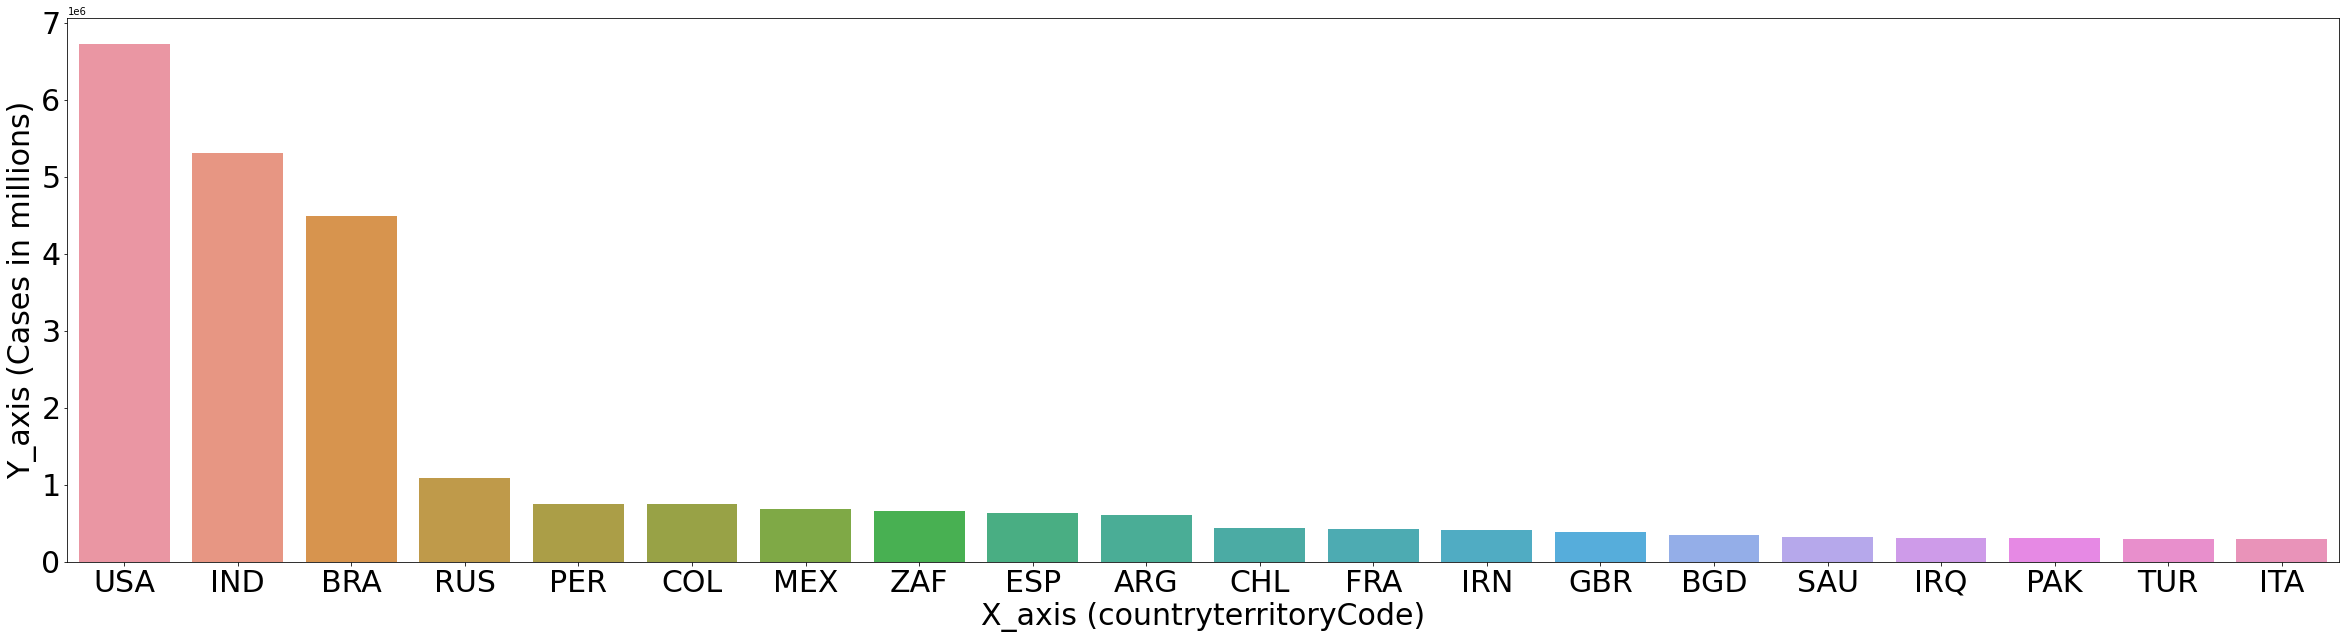

In [13]:
# Plot a barplot with the cases totals for the top 20 most affected countries 
a4_dims = (40.7, 10)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.barplot(x="countryterritoryCode", y="total_cases_country", data=df)

ax.set_xlabel('X_axis (countryterritoryCode)',fontsize=30);
ax.set_ylabel('Y_axis (Cases in millions)',fontsize=30);
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

In [14]:
# Obtain the death totals of the top 20 most affected countries 
Query_string = """ select sum(deaths) as total_deaths_country, countriesAndTerritories, countryterritoryCode from ts group by countriesAndTerritories order by total_deaths_country desc limit 20;"""
df = sqldf(Query_string, globals())
df

,total_deaths_country,countriesAndTerritories,countryterritoryCode
0,198589,United_States_of_America,USA
1,135793,Brazil,BRA
2,85619,India,IND
3,72803,Mexico,MEX
4,41732,United_Kingdom,GBR
5,35652,Italy,ITA
6,32005,Spain,ESP
7,31281,Peru,PER
8,31142,France,FRA
9,23952,Iran,IRN


(array([     0.,  25000.,  50000.,  75000., 100000., 125000., 150000.,
        175000., 200000., 225000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

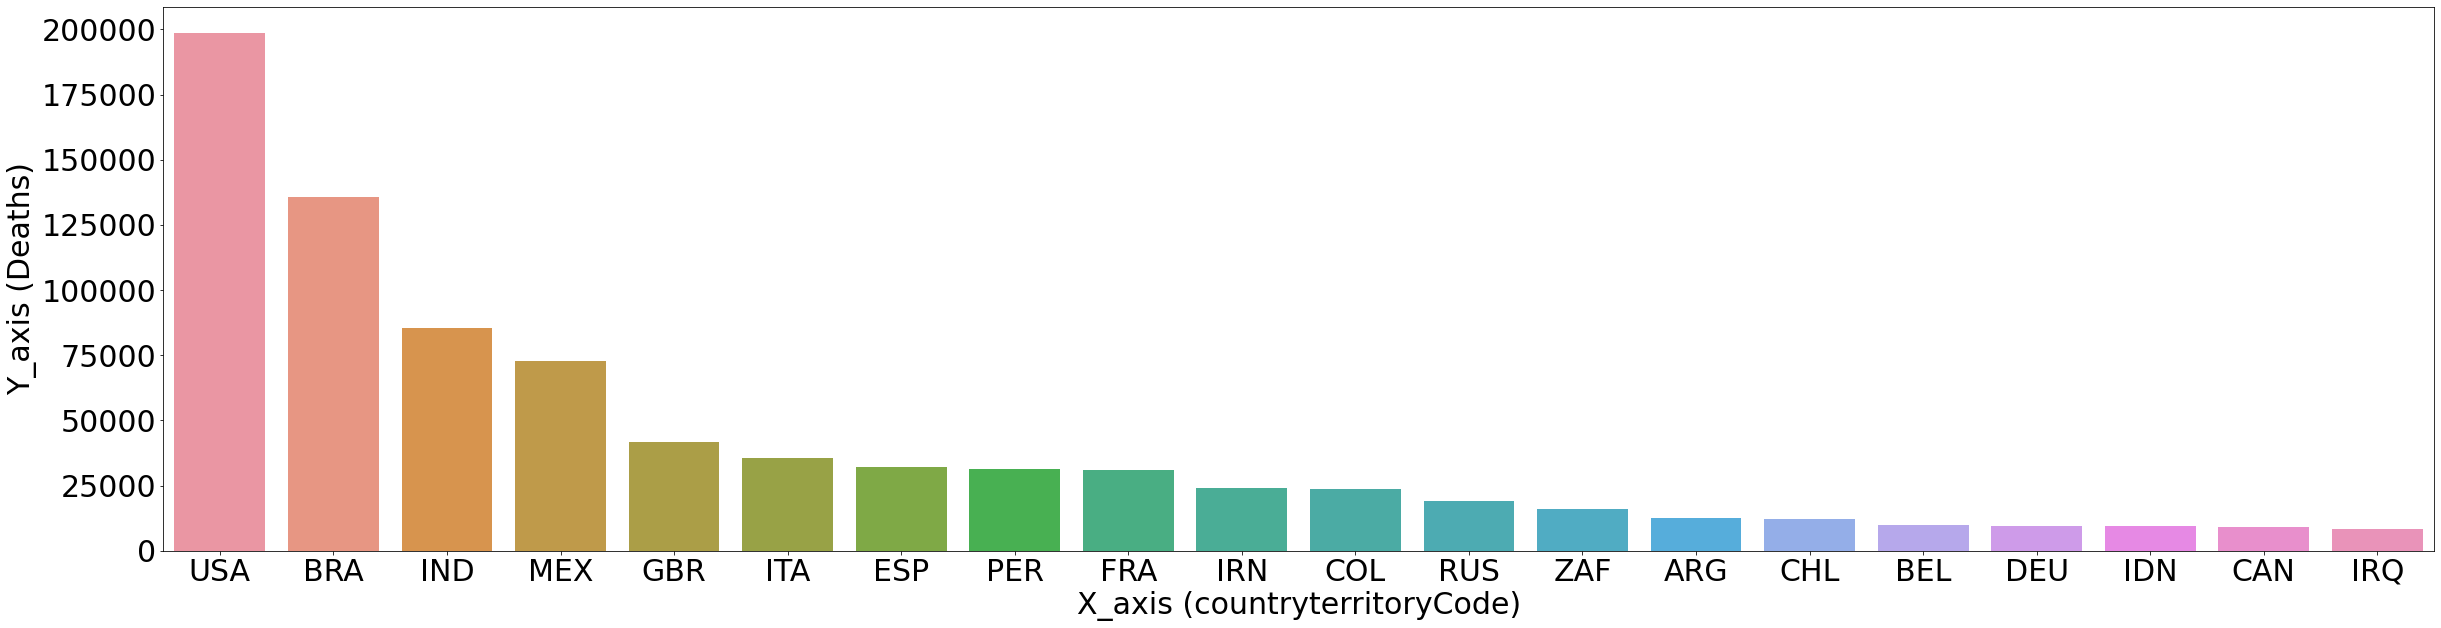

In [15]:
# Plot a barplot with the deaths totals for the top 20 most affected countries 
a4_dims = (40.7, 10)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.barplot(x="countryterritoryCode", y="total_deaths_country", data=df)

ax.set_xlabel('X_axis (countryterritoryCode)',fontsize=30);
ax.set_ylabel('Y_axis (Deaths)',fontsize=30);
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

In [16]:
# Obtain the case and death totals for the five continents
Query_string = """ select  sum(cases) as tot_cases_continent, sum(deaths) as tot_deaths_continent, continentExp  from ts group by continentExp ;"""
    
df = sqldf(Query_string, globals())
df

,tot_cases_continent,tot_deaths_continent,continentExp
0,1379730,33474,Africa
1,15506509,524537,America
2,9173497,172756,Asia
3,4438071,218638,Europe
4,32082,905,Oceania


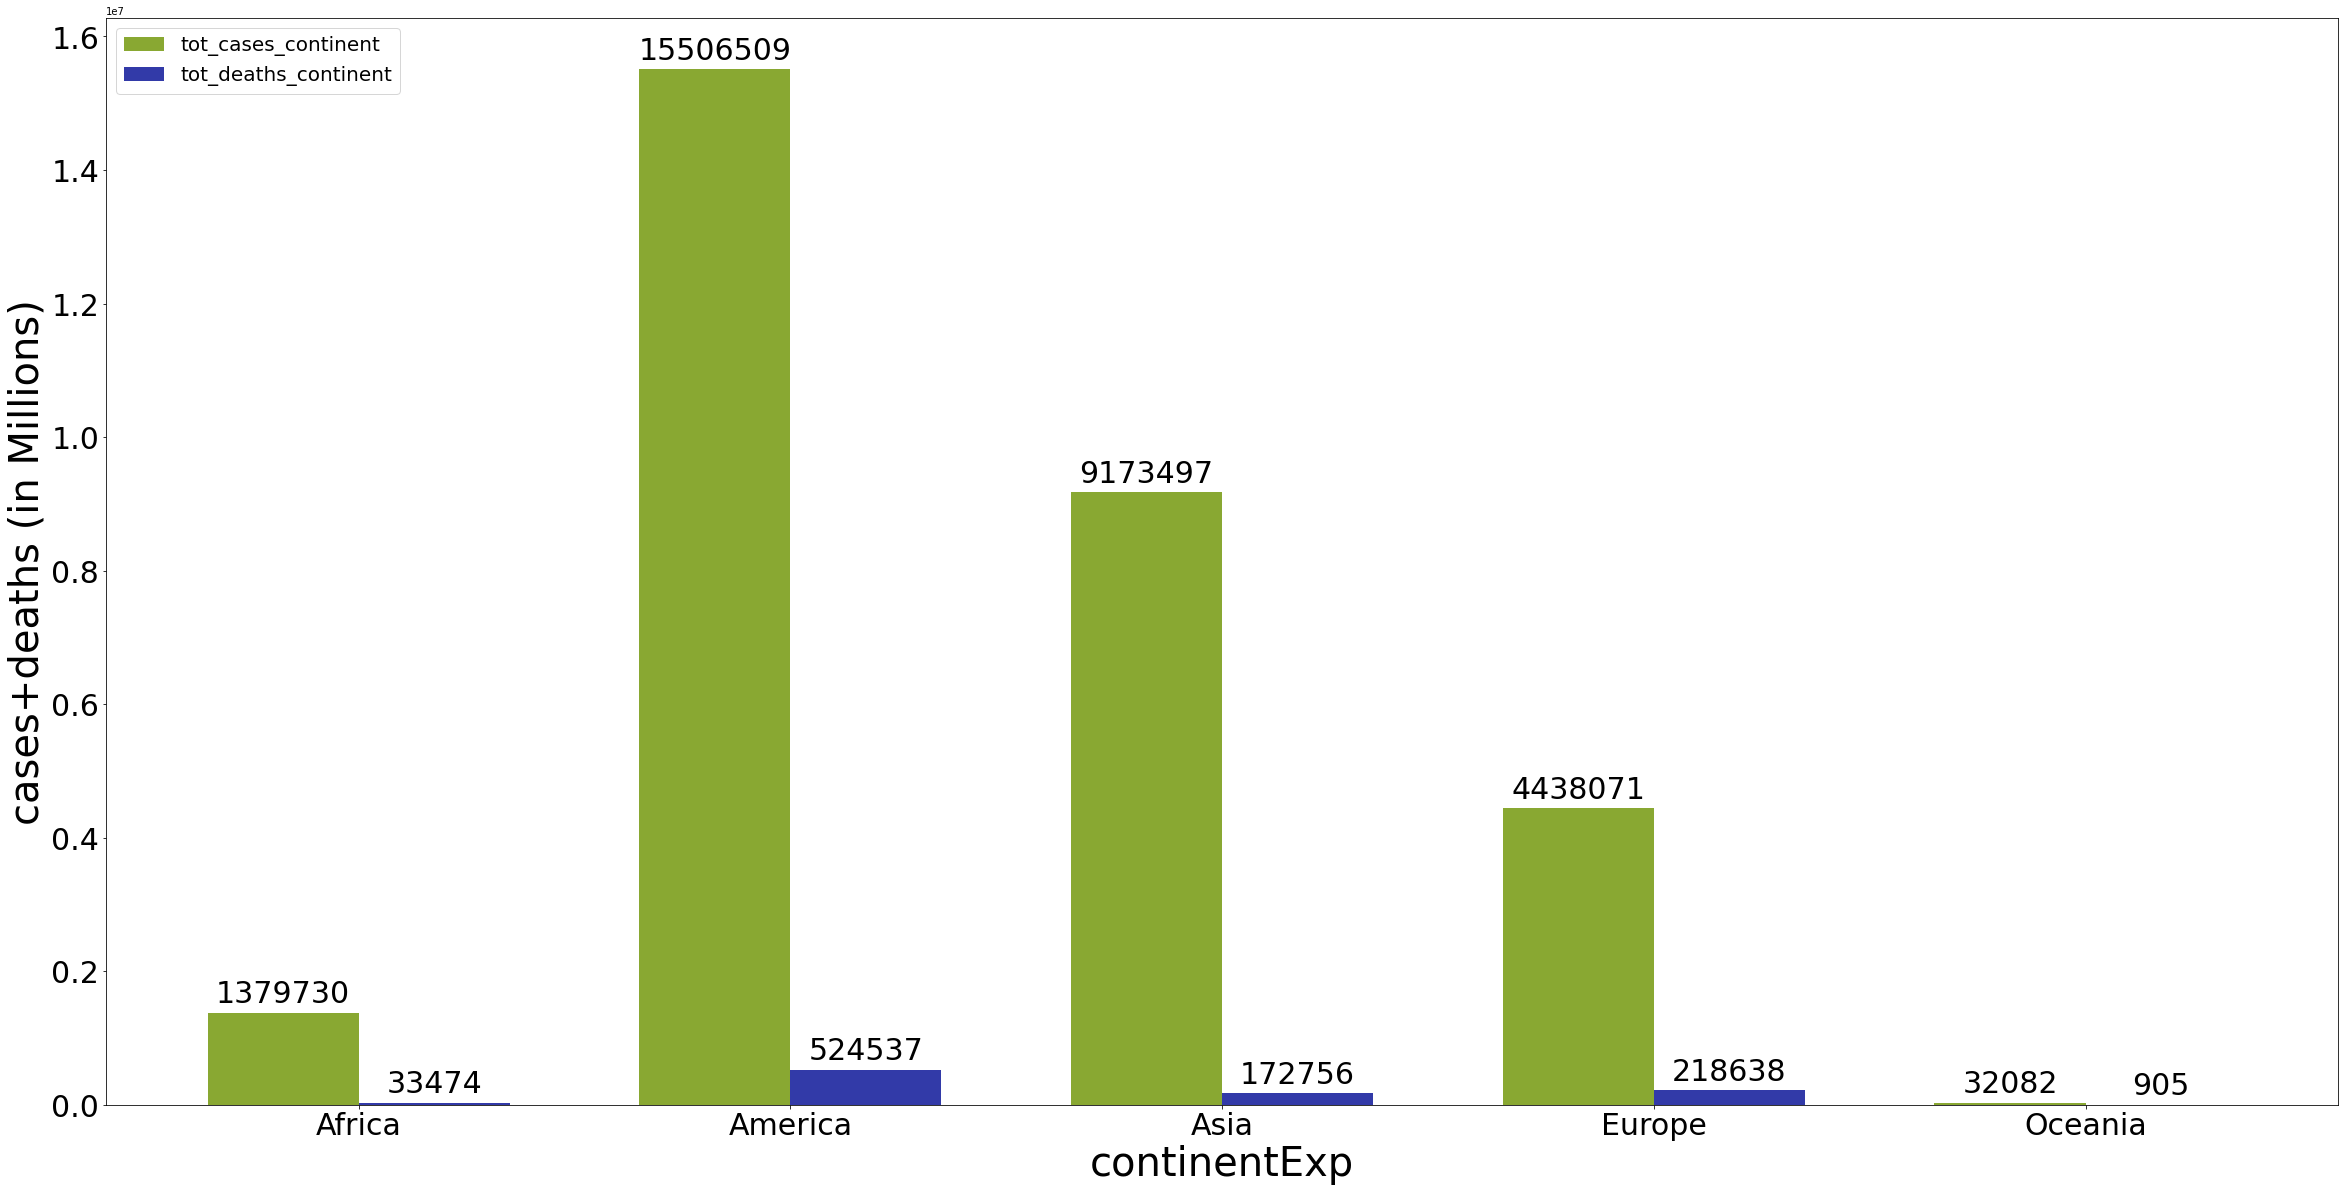

In [17]:
# Plot a side-by-side barplot using cases and deaths totals for the continents
labels = df['continentExp']
ind = np.arange(len(labels))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(40,20))
rects1 = ax.bar(ind - width/2, df['tot_cases_continent'], width,
                label='tot_cases_continent',color="#89a832")
rects2 = ax.bar(ind + width/2, df['tot_deaths_continent'], width,
                label='tot_deaths_continent',color="#323aa8")

def autolabel(rects, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}

    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(offset[xpos]*3, 4),  # use 3 points offset
                    textcoords="offset points",  # in both directions
                    ha=ha[xpos], va='bottom',fontsize=30)


autolabel(rects1, "center")
autolabel(rects2, "center")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('cases+deaths (in Millions)',fontsize=40)
ax.set_xlabel('continentExp',fontsize=40)
ax.set_xticks(ind)
ax.set_xticklabels(labels,fontsize=30)
plt.yticks(fontsize=30)
ax.legend()

ax.legend(loc='upper left', fontsize=20)


In [18]:
# Obtain the daily cases for five most affected countries - "United_States_of_America","Brazil","India","Mexico","United_Kingdom"
Query_string = """ select  Date, cases, countriesAndTerritories from ts where countriesAndTerritories in ("United_States_of_America","Brazil","India","Mexico","United_Kingdom");"""
    
df = sqldf(Query_string, globals())
df

,Date,cases,countriesAndTerritories
0,2020-01-13 00:00:00.000000,0,Brazil
1,2020-01-13 00:00:00.000000,0,India
2,2020-01-13 00:00:00.000000,0,United_States_of_America
3,2020-01-13 00:00:00.000000,0,Mexico
4,2020-01-13 00:00:00.000000,0,United_Kingdom
...,...,...,...
1241,2020-09-19 00:00:00.000000,39797,Brazil
1242,2020-09-19 00:00:00.000000,50209,United_States_of_America
1243,2020-09-19 00:00:00.000000,4322,United_Kingdom
1244,2020-09-19 00:00:00.000000,4841,Mexico


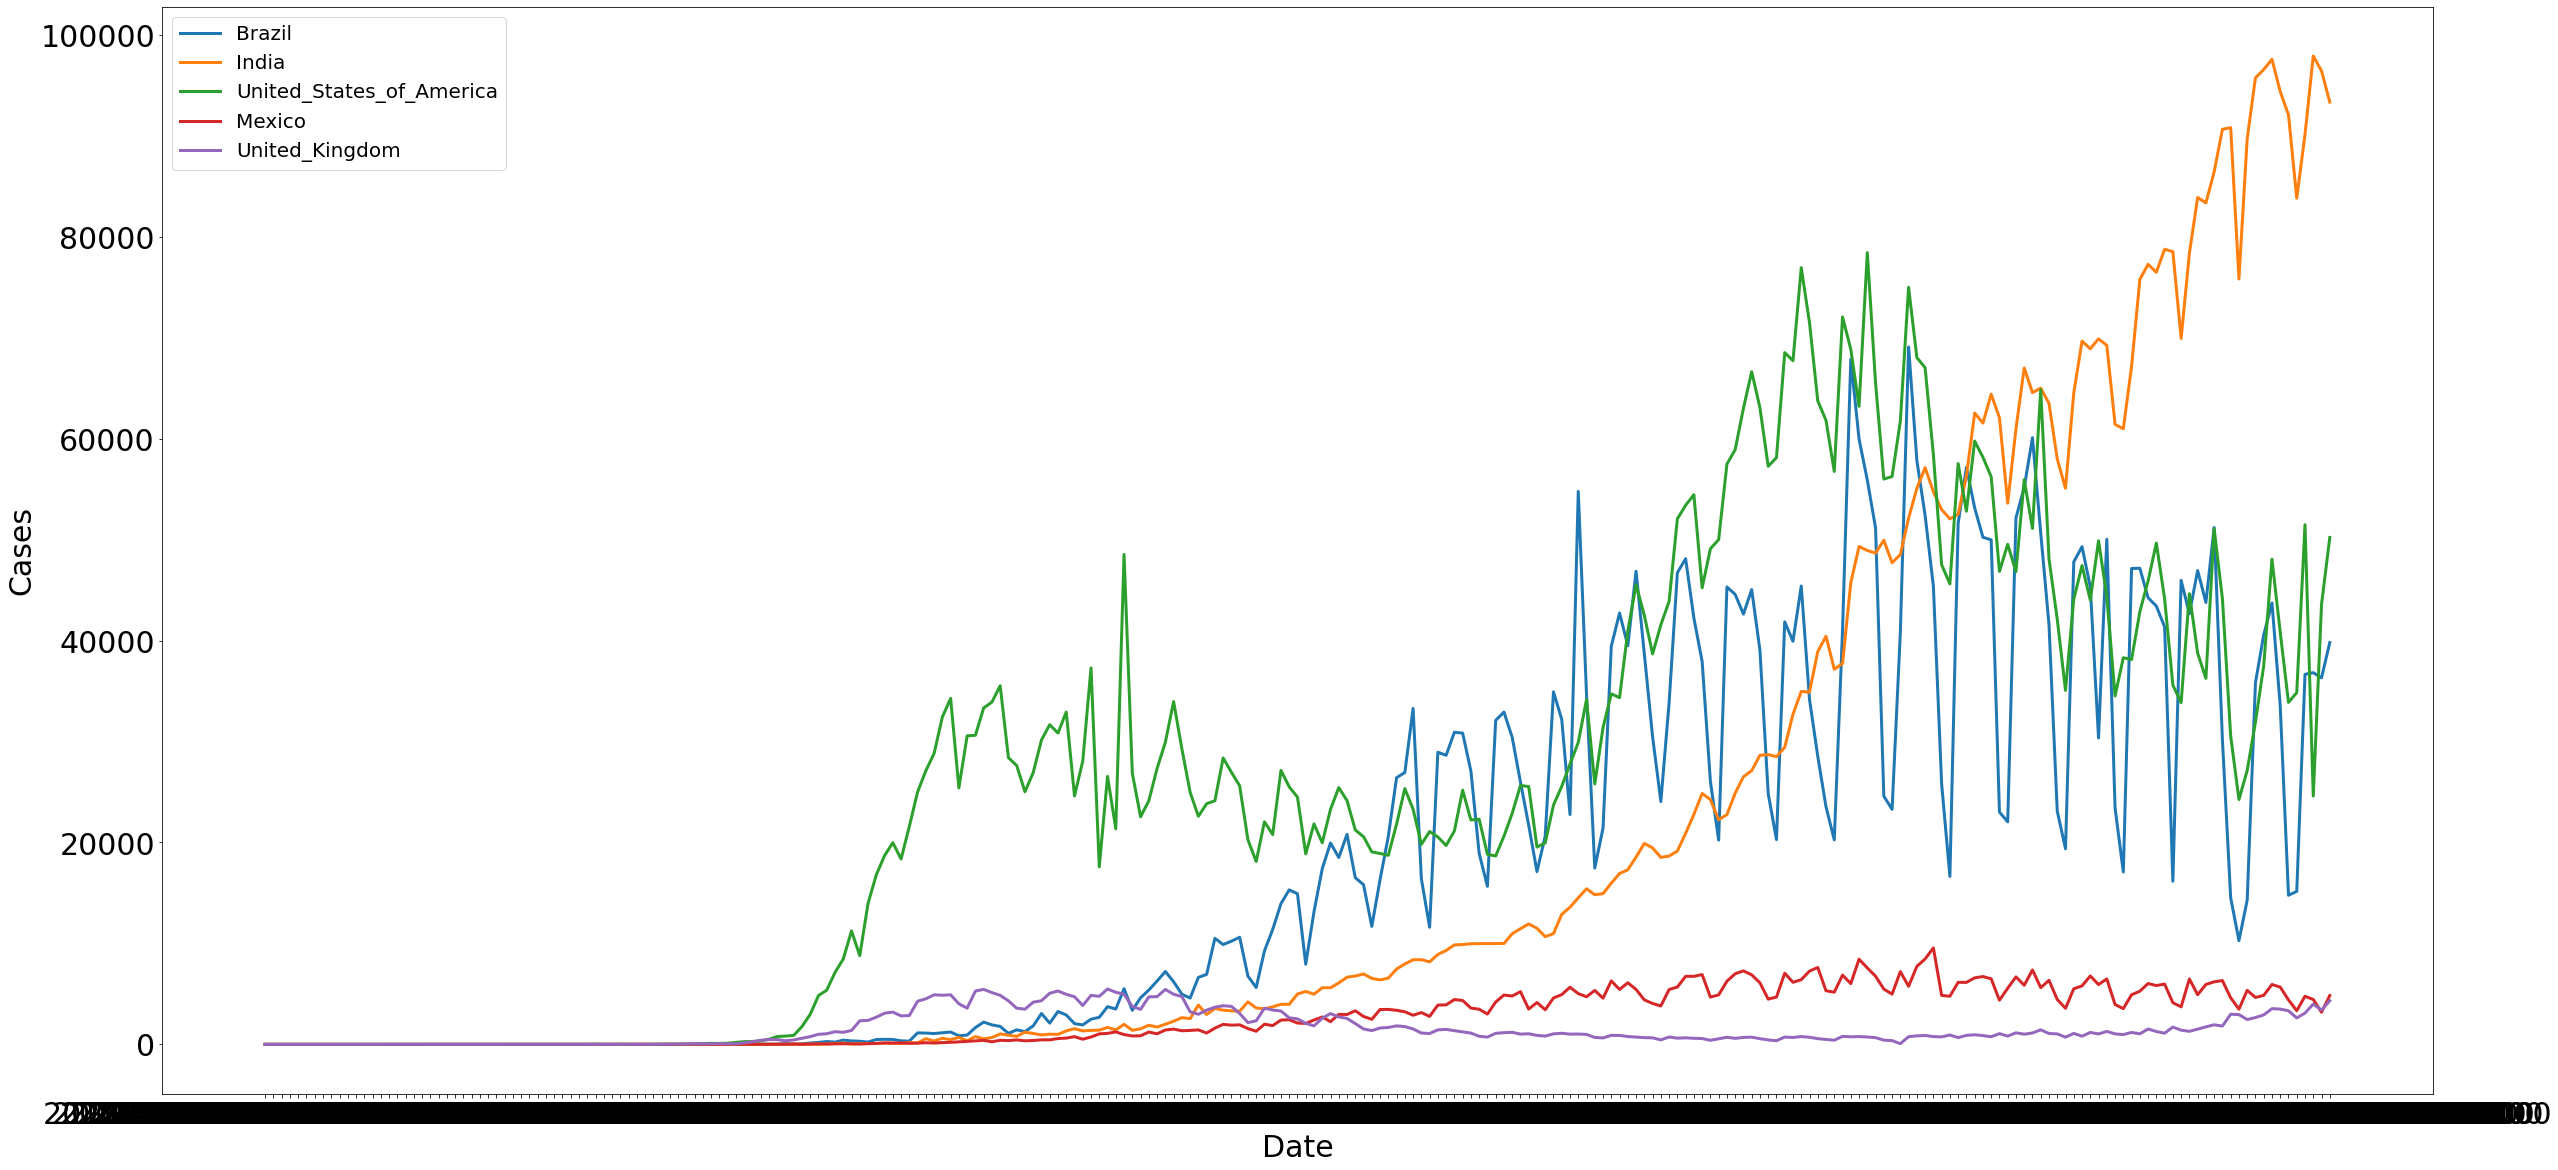

In [19]:
# TimePlot of cases for the top 5 most affected countries 
a4_dims = (40.7, 20)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.lineplot(x="Date", y="cases",
             hue="countriesAndTerritories",
             data=df)
plt.setp(ax.lines,linewidth=3)  # set lw for all lines of g axes

ax.legend(loc='upper left', fontsize=20)
ax.set_xlabel('Date',fontsize=30);
ax.set_ylabel('Cases',fontsize=30);
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

plt.show()

In [20]:
# Obtain the daily deaths for five most affected countries - "United_States_of_America","Brazil","India","Mexico","United_Kingdom"
Query_string = """ select Date, deaths, countriesAndTerritories from ts where countriesAndTerritories in ("United_States_of_America","Brazil","India","Mexico","United_Kingdom");"""
    
df = sqldf(Query_string, globals())
df

,Date,deaths,countriesAndTerritories
0,2020-01-13 00:00:00.000000,0,Brazil
1,2020-01-13 00:00:00.000000,0,India
2,2020-01-13 00:00:00.000000,0,United_States_of_America
3,2020-01-13 00:00:00.000000,0,Mexico
4,2020-01-13 00:00:00.000000,0,United_Kingdom
...,...,...,...
1241,2020-09-19 00:00:00.000000,858,Brazil
1242,2020-09-19 00:00:00.000000,956,United_States_of_America
1243,2020-09-19 00:00:00.000000,27,United_Kingdom
1244,2020-09-19 00:00:00.000000,624,Mexico


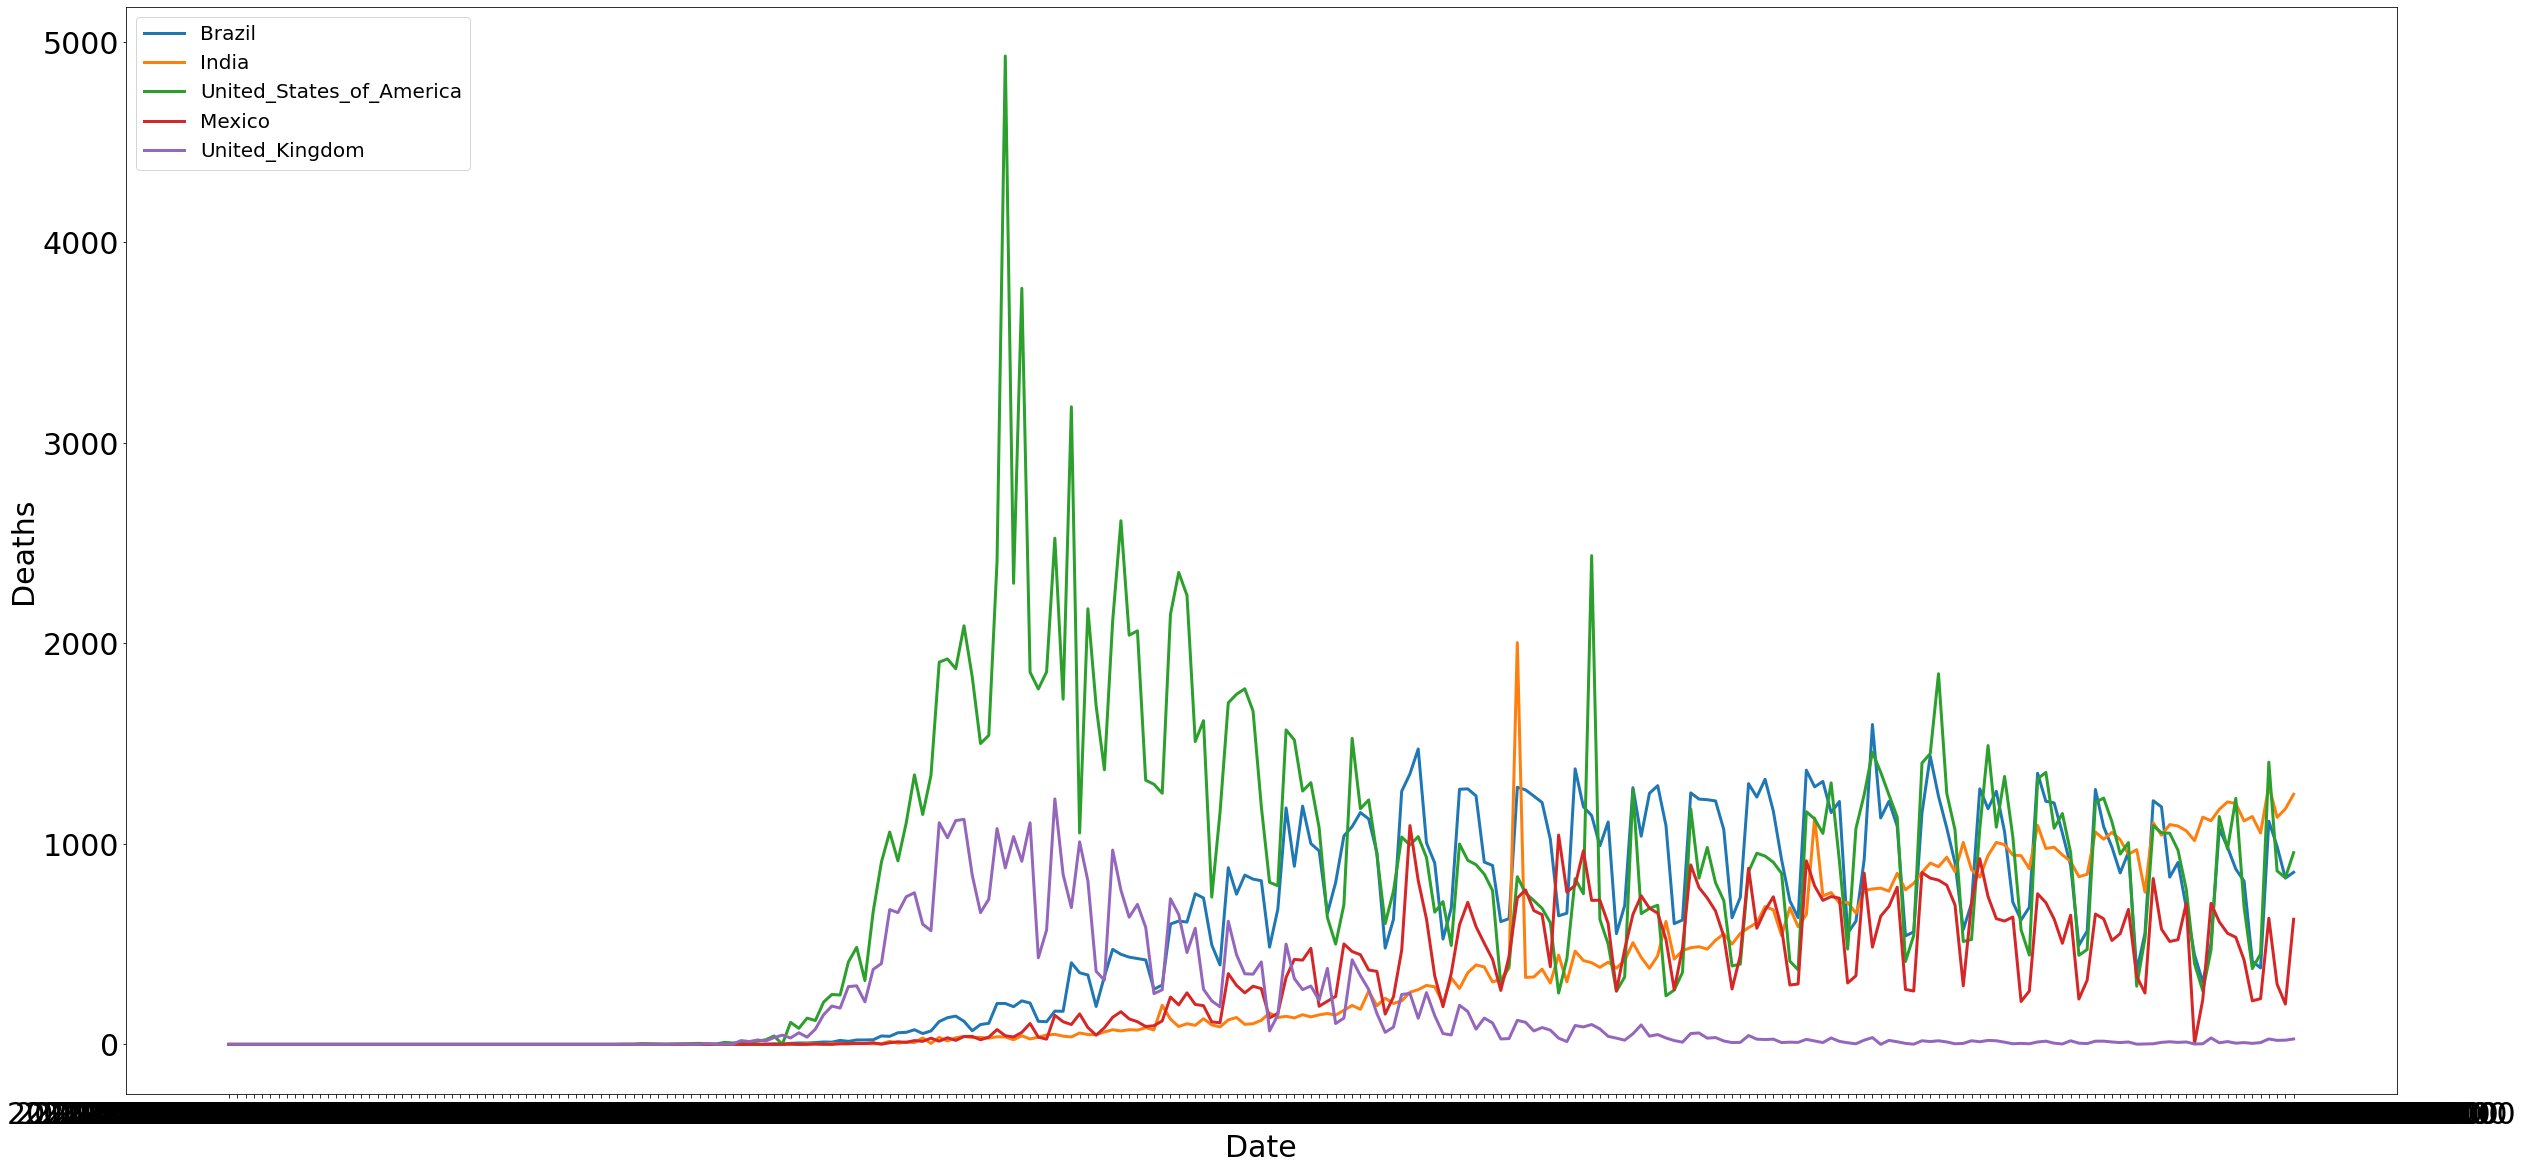

In [21]:
# TimePlot of deaths for the top 5 most affected countries 
a4_dims = (40.7, 20)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.lineplot(x="Date", y="deaths",
             hue="countriesAndTerritories",
             data=df)

plt.setp(ax.lines,linewidth=3)  # set lw for all lines of g axes

ax.legend(loc='upper left', fontsize=20)
ax.set_xlabel('Date',fontsize=30);
ax.set_ylabel('Deaths',fontsize=30);
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

plt.show()

In [22]:
# Obtain the Cumulative_number_for_14_days_of_COVID_19_cases_per_100000 for five most affected countries - "United_States_of_America","Brazil","India","Mexico","United_Kingdom"
Query_string = """ select Date, Cumulative_number_for_14_days_of_COVID_19_cases_per_100000, countriesAndTerritories from ts where countriesAndTerritories in ("United_States_of_America","Brazil","India","Mexico","United_Kingdom");"""
    
df = sqldf(Query_string, globals())
df

,Date,Cumulative_number_for_14_days_of_COVID_19_cases_per_100000,countriesAndTerritories
0,2020-01-13 00:00:00.000000,0.000000,Brazil
1,2020-01-13 00:00:00.000000,0.000000,India
2,2020-01-13 00:00:00.000000,0.000000,United_States_of_America
3,2020-01-13 00:00:00.000000,0.000000,Mexico
4,2020-01-13 00:00:00.000000,0.000000,United_Kingdom
...,...,...,...
1241,2020-09-19 00:00:00.000000,190.642936,Brazil
1242,2020-09-19 00:00:00.000000,158.917275,United_States_of_America
1243,2020-09-19 00:00:00.000000,65.396682,United_Kingdom
1244,2020-09-19 00:00:00.000000,51.627456,Mexico


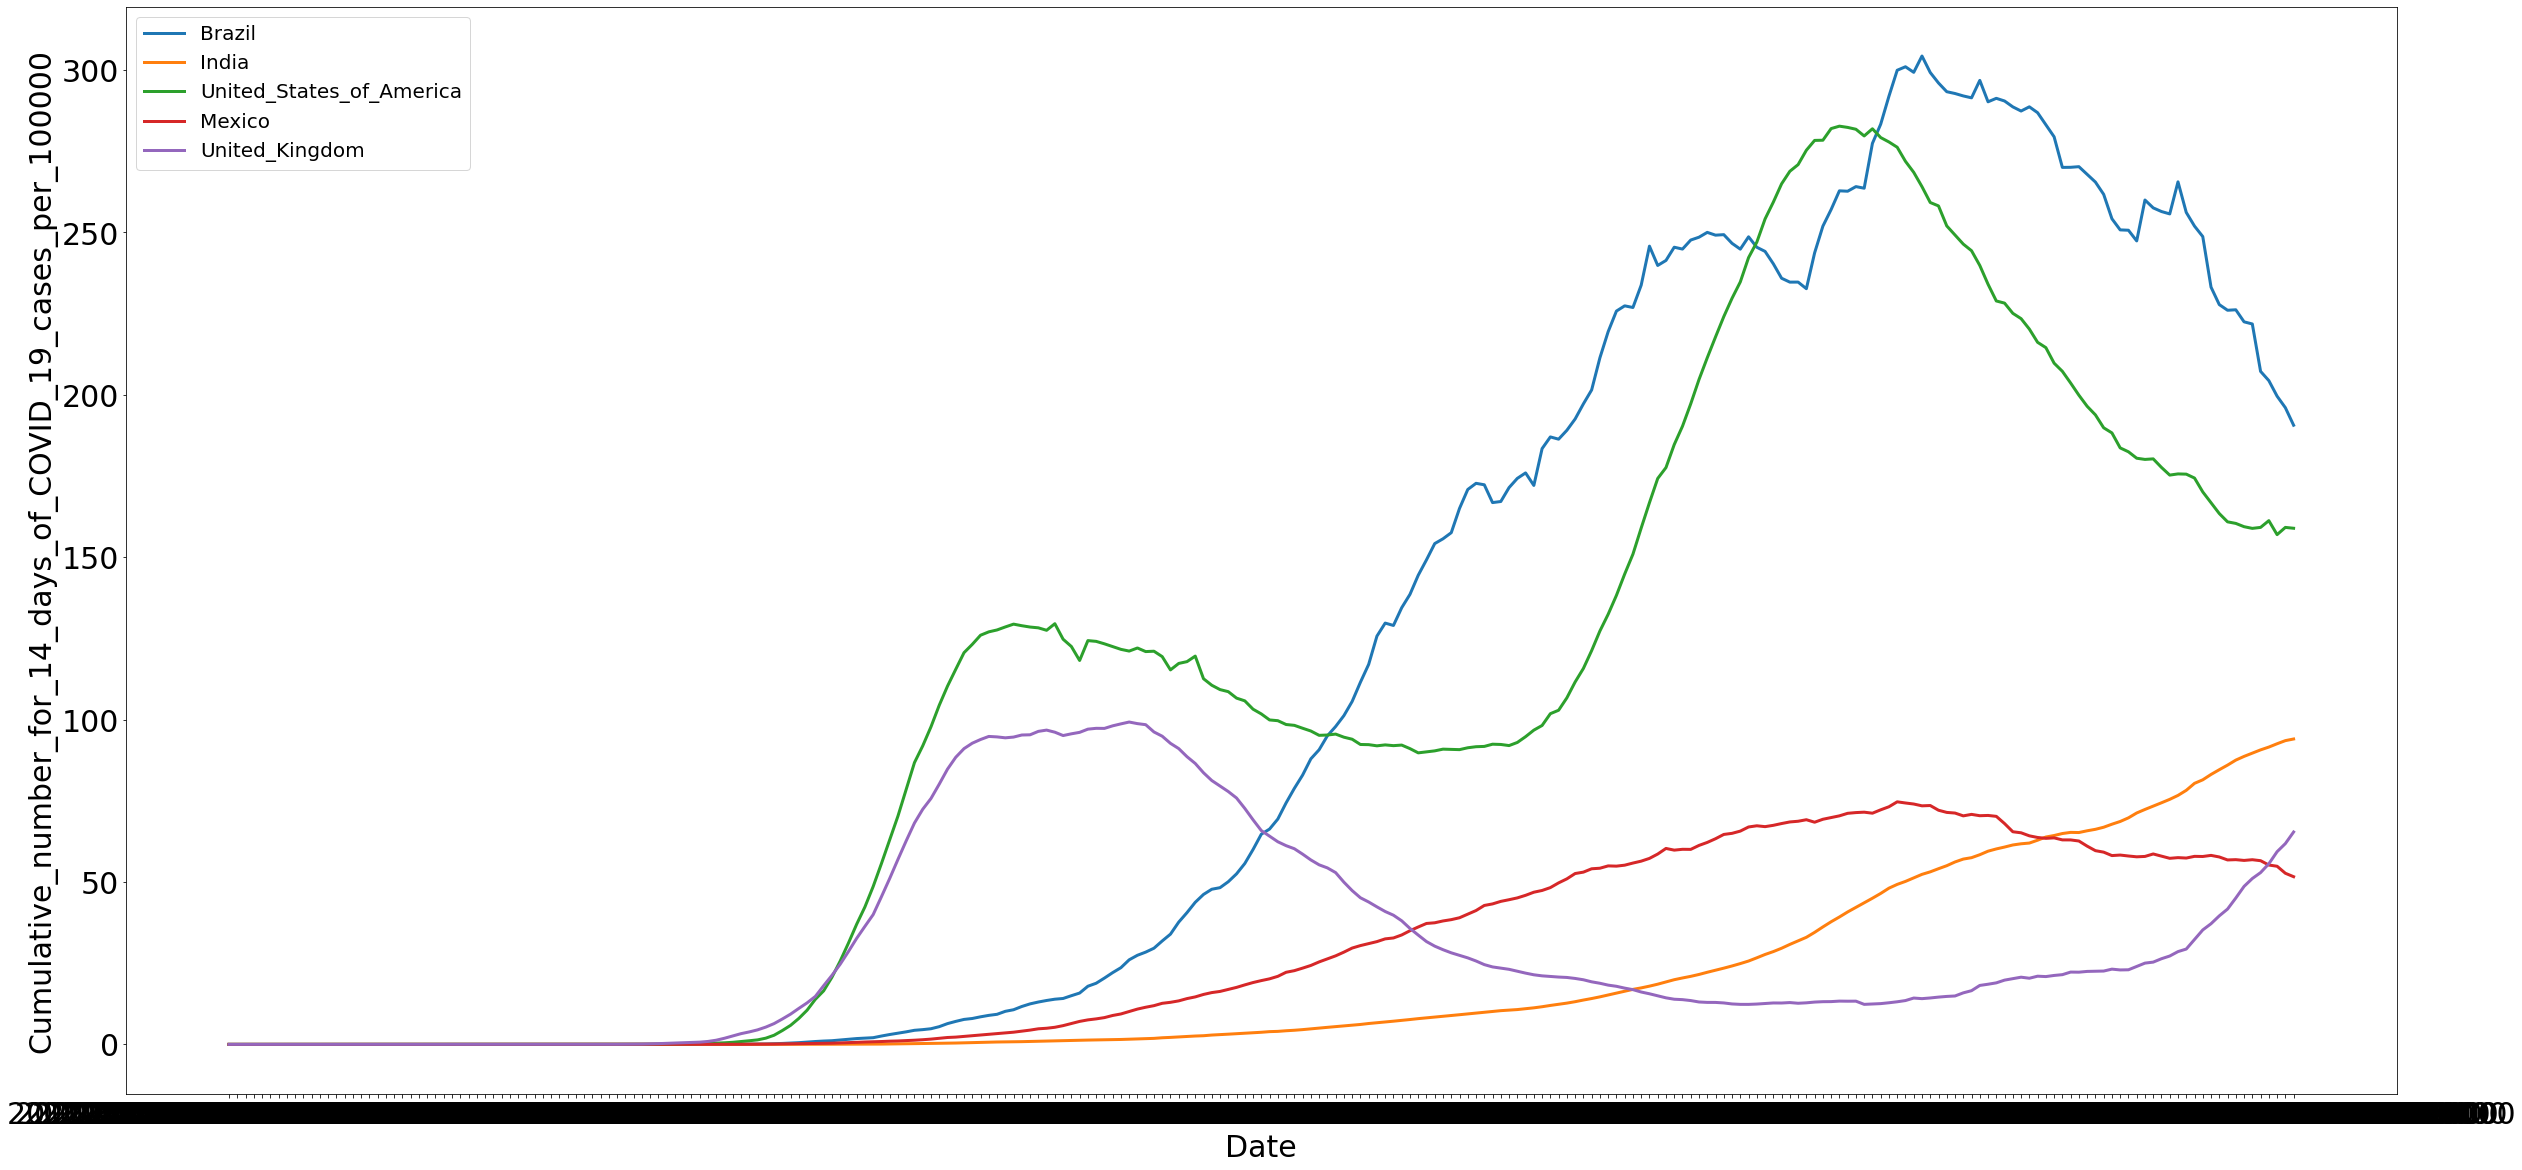

In [23]:
# TimePlot of Cumulative_number_for_14_days_of_COVID_19_cases_per_100000 for the top 5 most affected countries 
a4_dims = (40.7, 20)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.lineplot(x="Date", y="Cumulative_number_for_14_days_of_COVID_19_cases_per_100000",
             hue="countriesAndTerritories",
             data=df)

plt.setp(ax.lines,linewidth=3)  # set lw for all lines of g axes

ax.legend(loc='upper left', fontsize=20)
ax.set_xlabel('Date',fontsize=30);
ax.set_ylabel('Cumulative_number_for_14_days_of_COVID_19_cases_per_100000',fontsize=30);
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

plt.show()

In [24]:
# Obtain total cases, total deaths for the ten most affected countries 
Query_string = """ select sum(cases) as tot_cases, sum(deaths) as tot_deaths, countriesAndTerritories from ts where countriesAndTerritories in ("United_States_of_America","Brazil","India","Mexico","United_Kingdom","Italy","Spain","France","Peru","Iran") group by countriesAndTerritories order by tot_cases desc;"""
    
df = sqldf(Query_string, globals())
df

,tot_cases,tot_deaths,countriesAndTerritories
0,6724667,198589,United_States_of_America
1,5308014,85619,India
2,4495183,135793,Brazil
3,756178,31281,Peru
4,688954,72803,Mexico
5,637953,32005,Spain
6,429462,31142,France
7,416198,23952,Iran
8,385936,41732,United_Kingdom
9,294503,35652,Italy


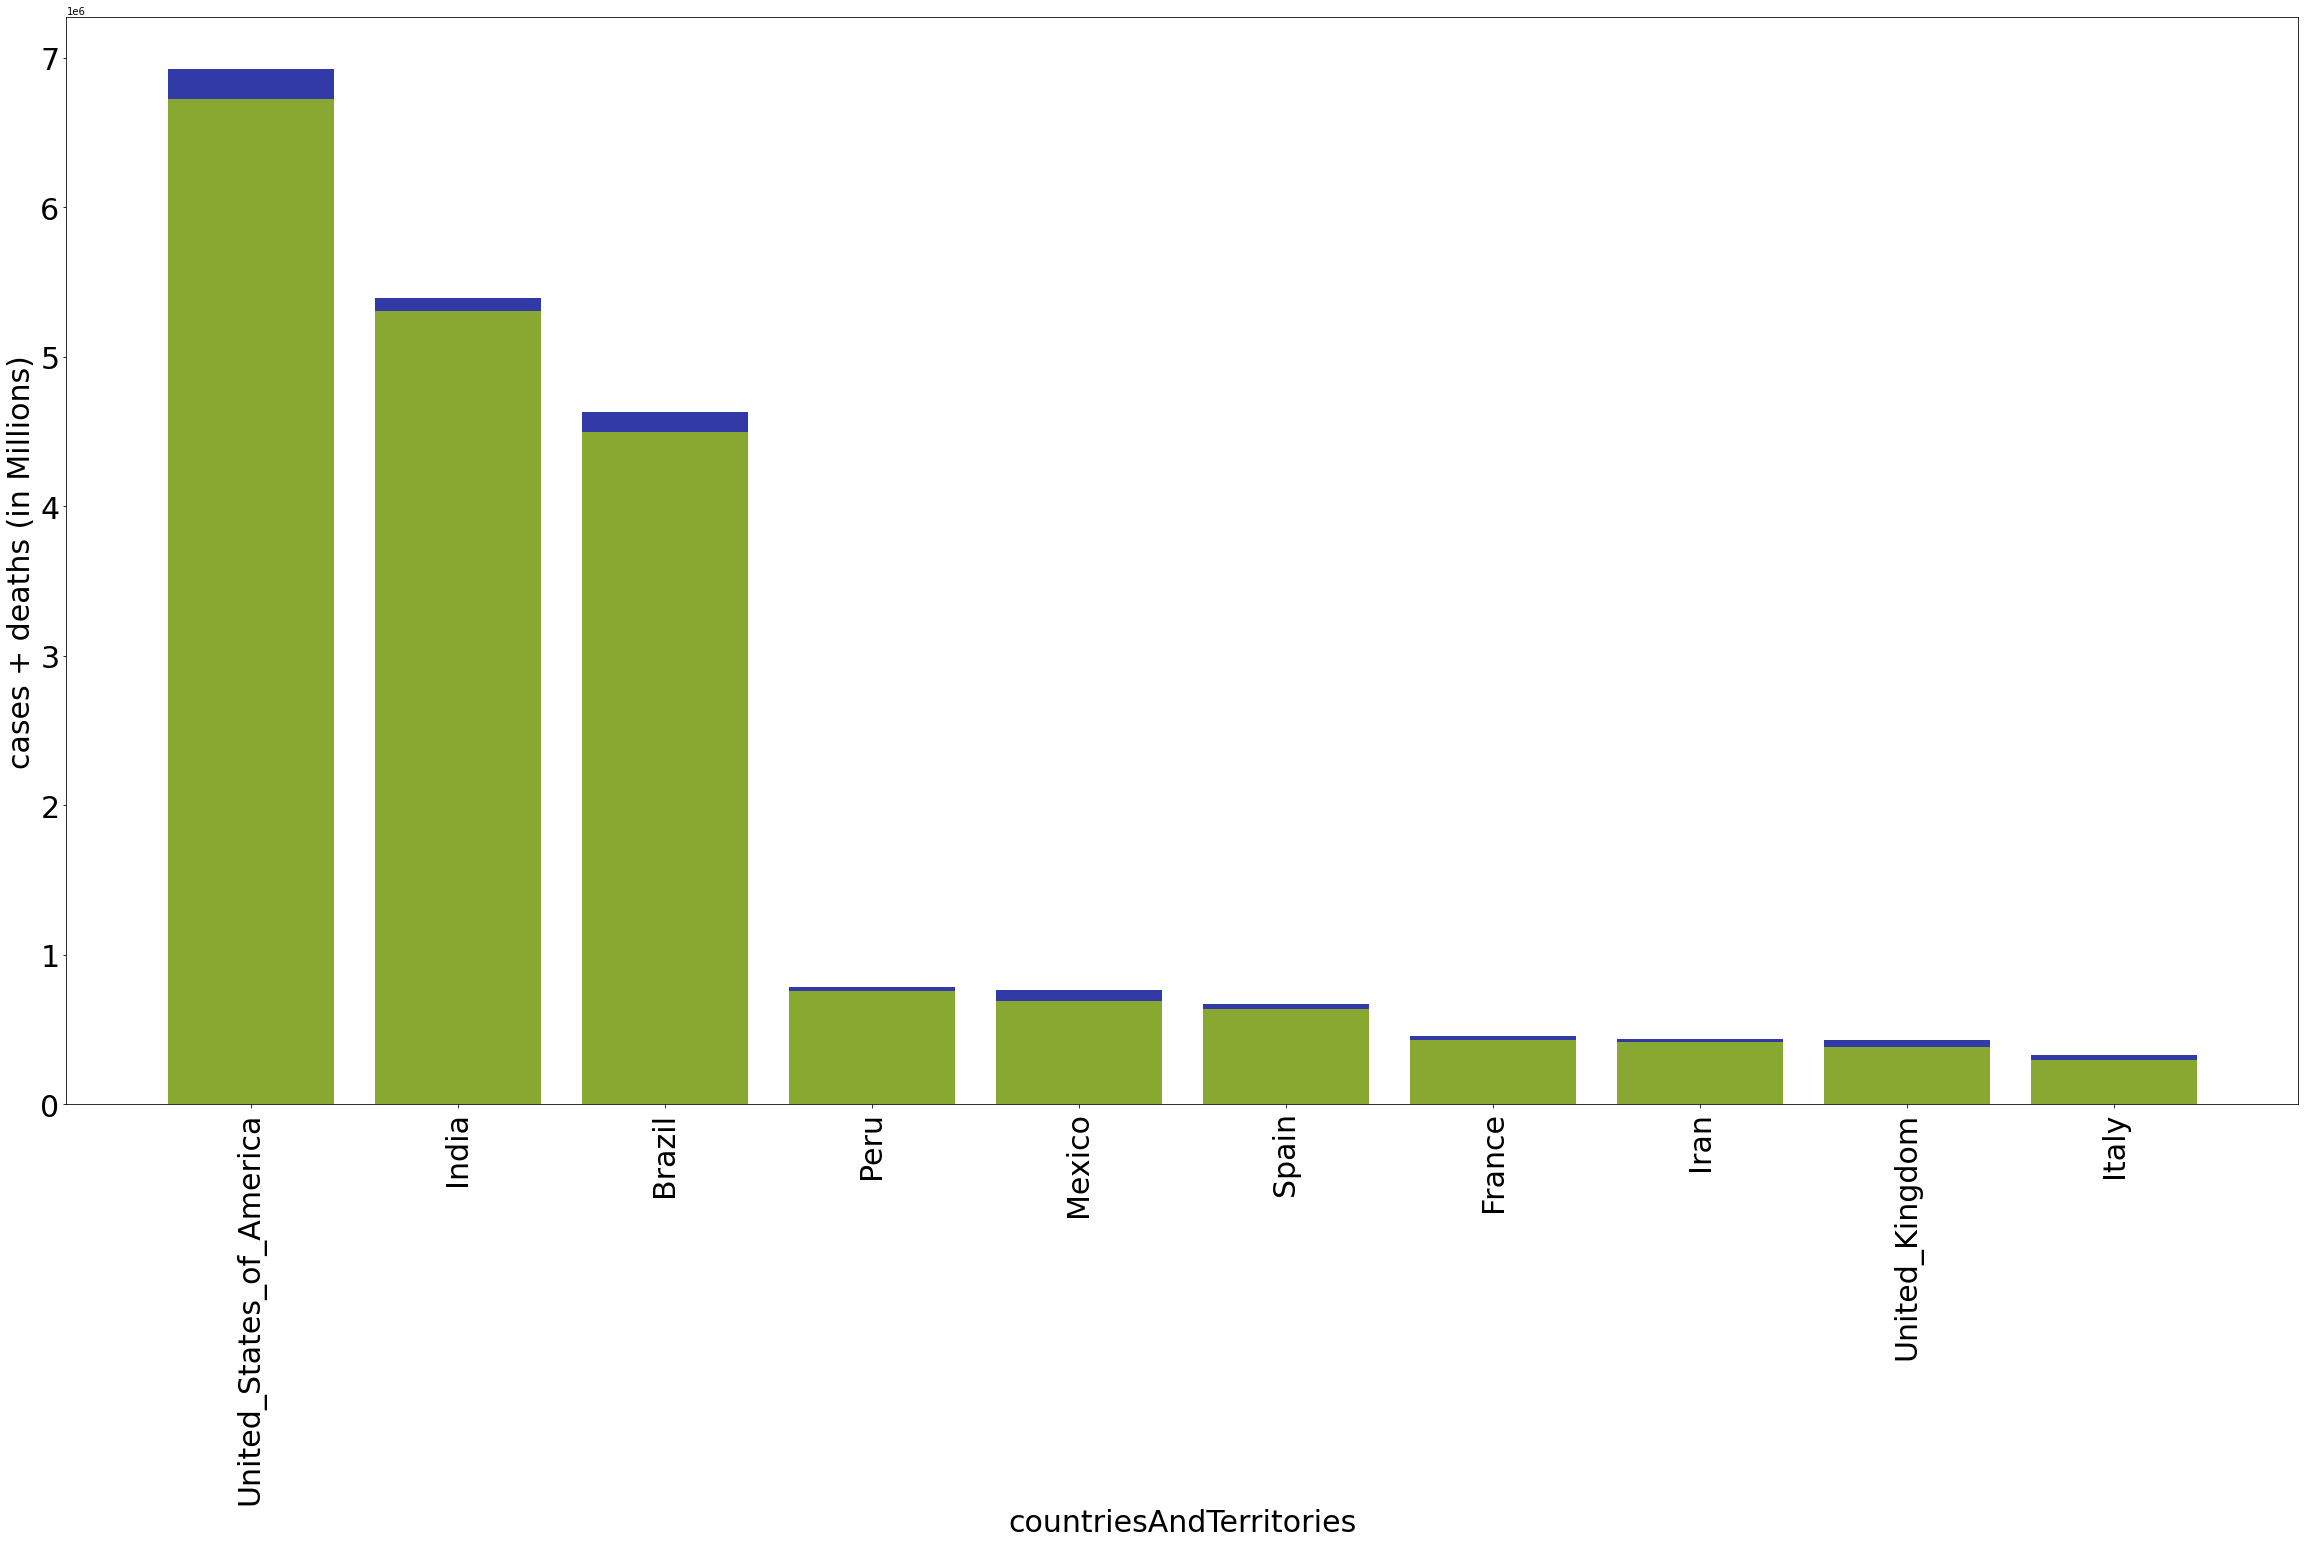

In [25]:
#Stacked bar graph to show cases and deaths together for the top 10 most affected countries
plt.figure(figsize=(40,20))
plt.bar(df['countriesAndTerritories'], df['tot_cases'], color="#89a832")

# the second one is special to create stacked bar plots
plt.bar(df['countriesAndTerritories'], df['tot_deaths'], bottom=df['tot_cases'], color="#323aa8")

plt.xlabel('countriesAndTerritories',fontsize=30)  
plt.ylabel('cases + deaths (in Millions)',fontsize=30)
plt.xticks(fontsize=30, rotation=90)
plt.yticks(fontsize=30)

plt.show() 

In [26]:
# Next we compute the case fatality rate and the mortality rate TO DATE
# case fatality rate = (number of deaths / number of diagnosed cases) * 100
#
# mortality rate = (number of deaths / total population) * 100
#
# cases per million people = (number of cases / total population)*1000000
#
# deaths per million people = (number of deaths / total population)*1000000
#
# References:
# https://www.cebm.net/covid-19/global-covid-19-case-fatality-rates/
# https://www.worldometers.info/coronavirus/
# https://www.worldometers.info/coronavirus/coronavirus-death-rate/

Query_string = """ select sum(cases) as tot_cases, sum(deaths) as tot_deaths, countriesAndTerritories, countryterritoryCode from ts group by countriesAndTerritories """
df1 = sqldf(Query_string, globals())

Query_string = """select distinct popData2019, countriesAndTerritories from ts"""
df2 = sqldf(Query_string, globals())


df = df1.join(df2.set_index('countriesAndTerritories'), on='countriesAndTerritories')

df['caseFatalityRate'] = ((df['tot_deaths']/df['tot_cases'])*100).round(2)
df['mortalityRate'] = ((df['tot_deaths']/df['popData2019'])*100).round(2)
df['casesPerMil'] = ((df['tot_cases']/df['popData2019'])*1000000).round(2)
df['deathsPerMil'] = ((df['tot_deaths']/df['popData2019'])*1000000).round(2)
df = df.sort_values(['tot_deaths'],ascending=(False))
df.head(20)

,tot_cases,tot_deaths,countriesAndTerritories,countryterritoryCode,popData2019,caseFatalityRate,mortalityRate,casesPerMil,deathsPerMil
199,6724667,198589,United_States_of_America,USA,3.290649e+08,2.95,0.06,20435.69,603.49
27,4495183,135793,Brazil,BRA,2.110495e+08,3.02,0.06,21299.19,643.42
91,5308014,85619,India,IND,1.366418e+09,1.61,0.01,3884.62,62.66
125,688954,72803,Mexico,MEX,1.275755e+08,10.57,0.06,5400.36,570.67
196,385936,41732,United_Kingdom,GBR,6.664711e+07,10.81,0.06,5790.74,626.16
98,294503,35652,Italy,ITA,6.035955e+07,12.11,0.06,4879.15,590.66
177,637953,32005,Spain,ESP,4.693706e+07,5.02,0.07,13591.67,681.87
150,756178,31281,Peru,PER,3.251046e+07,4.14,0.10,23259.53,962.18
69,429462,31142,France,FRA,6.701288e+07,7.25,0.05,6408.65,464.72
93,416198,23952,Iran,IRN,8.291389e+07,5.75,0.03,5019.64,288.88


In [27]:
# Obtain the caseFatalityRate, mortalityRate for the top 10 most affected countries

Query_string = """ select caseFatalityRate, mortalityRate, countriesAndTerritories from df where countriesAndTerritories in ("United_States_of_America","Brazil","India","Mexico","United_Kingdom","Italy","Spain","France","Peru","Iran");"""
    
tbl = sqldf(Query_string, globals())

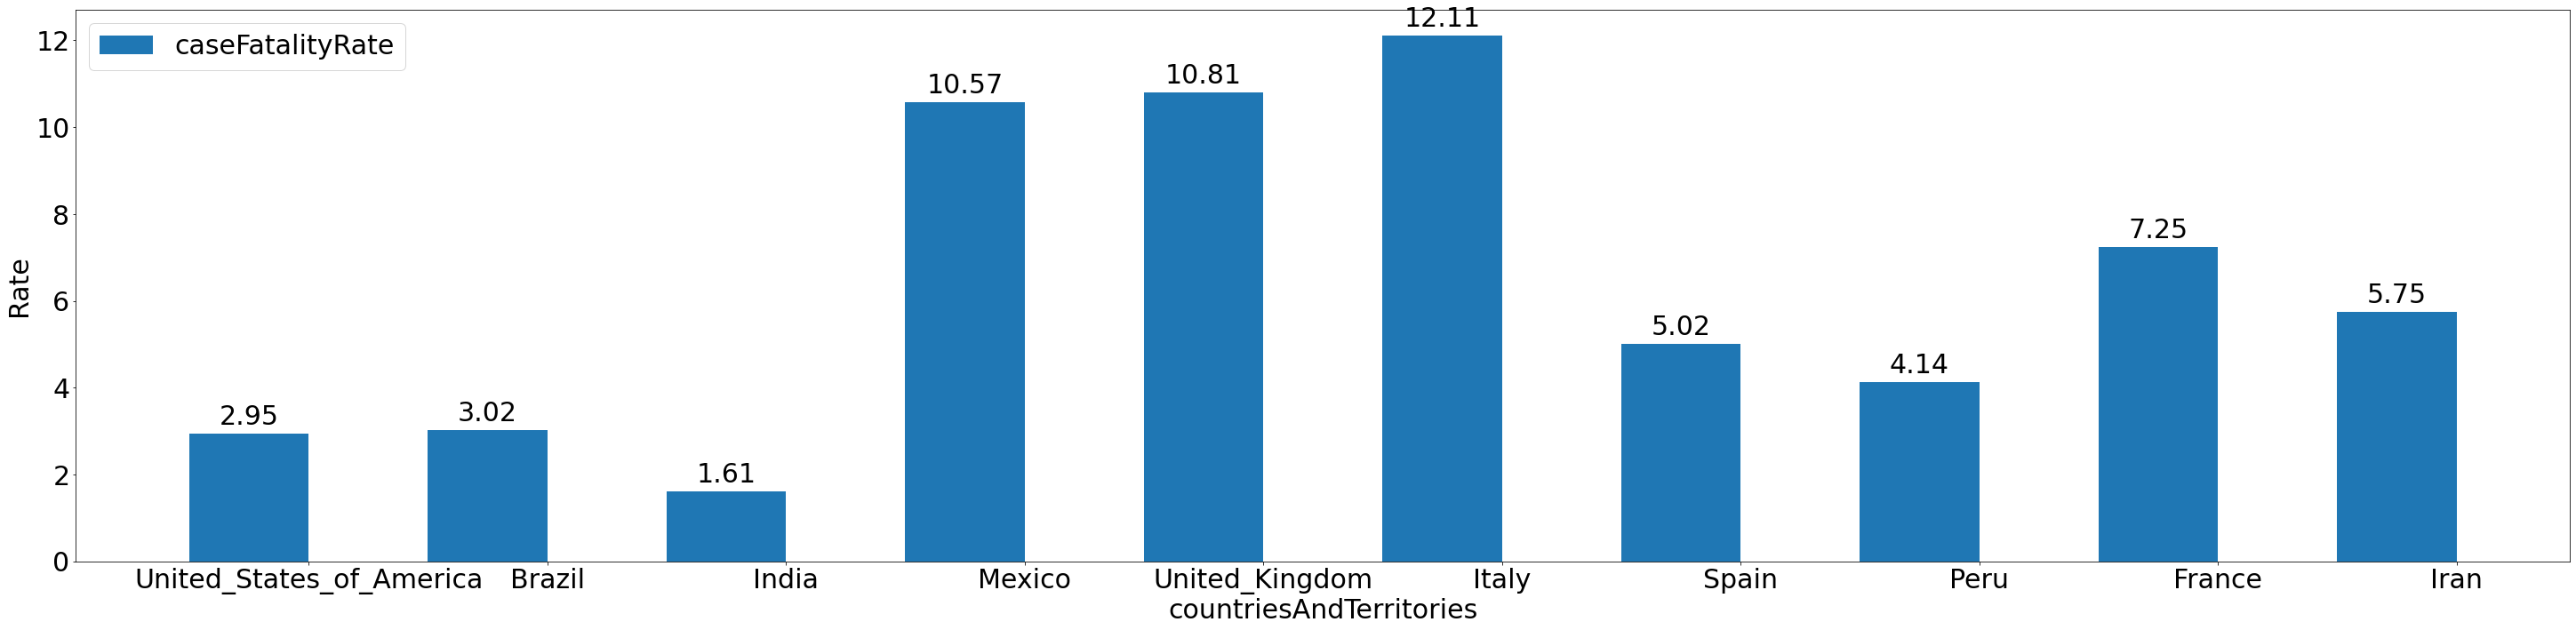

In [28]:
# Show a bar chart with the caseFatalityRates
labels = tbl['countriesAndTerritories']
ind = np.arange(len(labels))  # the x locations for the groups
width = 0.50  # the width of the bars

fig, ax = plt.subplots(figsize=(40,10))
rects1 = ax.bar(ind - width/2, tbl['caseFatalityRate'], width,
                label='caseFatalityRate')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Rate',fontsize=30)
ax.set_xlabel('countriesAndTerritories',fontsize=30)
ax.set_xticks(ind)
ax.set_xticklabels(labels,fontsize=30)
ax.legend()


def autolabel(rects, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}

    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(offset[xpos]*3, 4),  # use 3 points offset
                    textcoords="offset points",  # in both directions
                    ha=ha[xpos], va='bottom',fontsize=30)


autolabel(rects1, "center")

fig.tight_layout()


ax.legend(loc='upper left', fontsize=30)

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

plt.show()

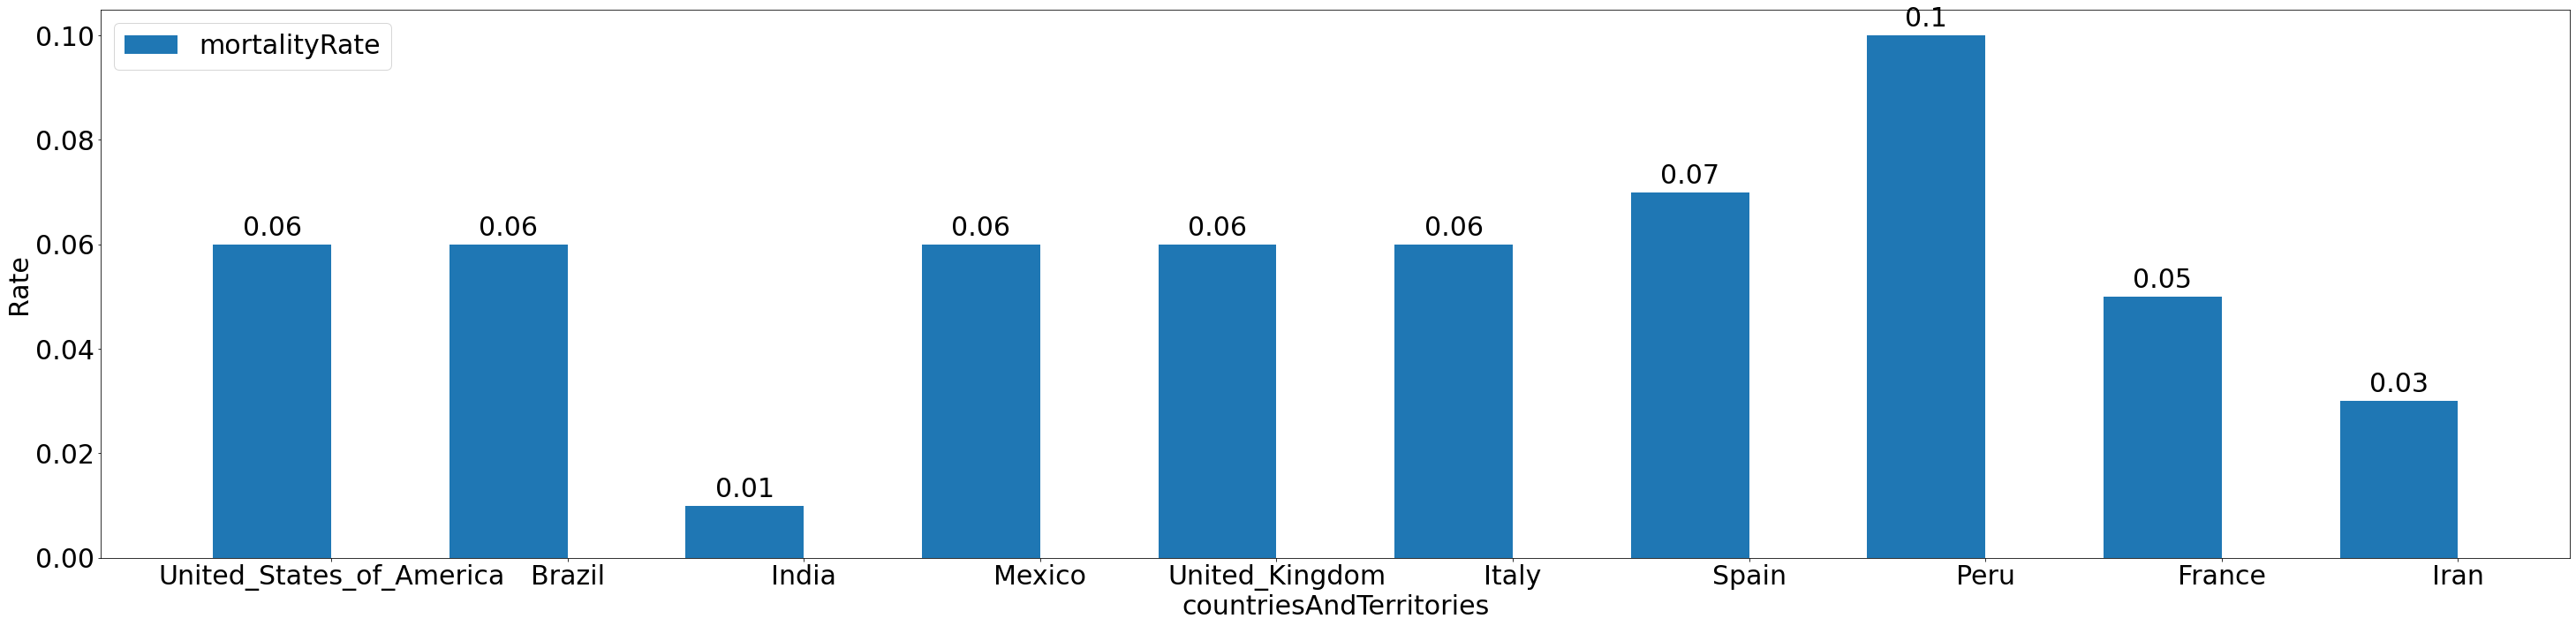

In [29]:
# Show a bar chart with the mortalityRates
labels = tbl['countriesAndTerritories']
ind = np.arange(len(labels))  # the x locations for the groups
width = 0.50  # the width of the bars

fig, ax = plt.subplots(figsize=(40,10))
rects1 = ax.bar(ind - width/2, tbl['mortalityRate'], width,
                label='mortalityRate')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Rate',fontsize=30)
ax.set_xlabel('countriesAndTerritories',fontsize=30)
ax.set_xticks(ind)
ax.set_xticklabels(labels,fontsize=30)
ax.legend()


def autolabel(rects, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}

    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(offset[xpos]*3, 4),  # use 3 points offset
                    textcoords="offset points",  # in both directions
                    ha=ha[xpos], va='bottom',fontsize=30)


autolabel(rects1, "center")

fig.tight_layout()


ax.legend(loc='upper left', fontsize=30)

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

plt.show()

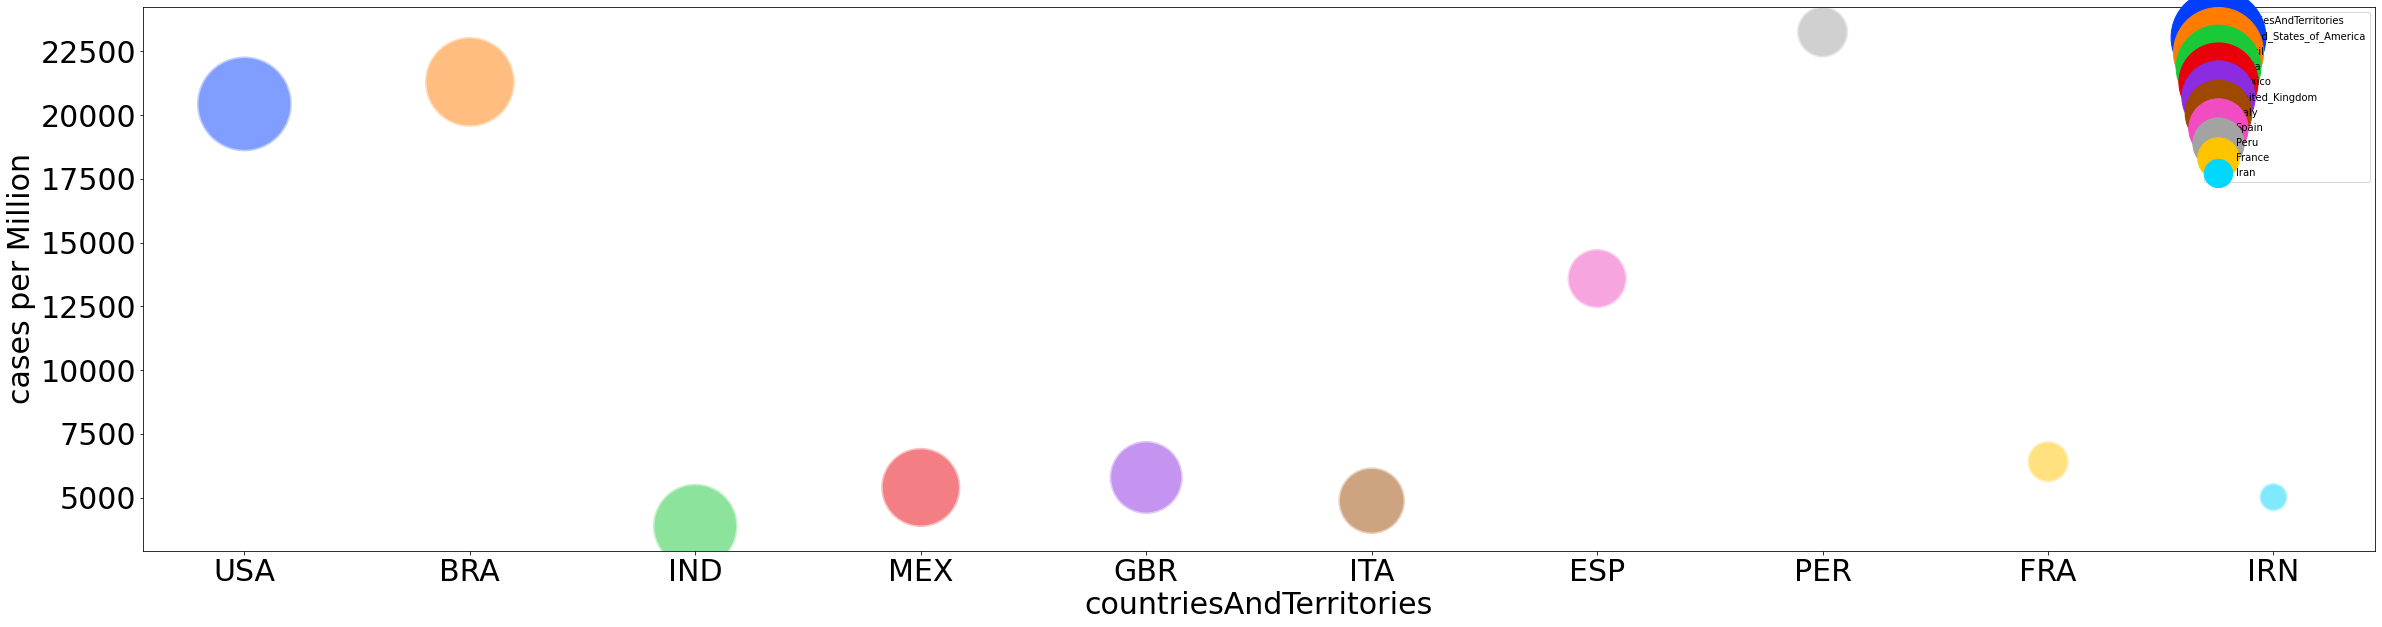

In [30]:
# Scatterplot with casesPerMil against countriesAndTerritories
df1 = df.iloc[0:10,]

fig, ax = plt.subplots(figsize=(40,10))
ax = sns.scatterplot(x = "countryterritoryCode", y = "casesPerMil", data=df1, size="countriesAndTerritories",hue="countriesAndTerritories",sizes=(800, 9000),alpha=.5, palette="bright")

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.xlabel('countriesAndTerritories',fontsize=30)  
plt.ylabel('cases per Million',fontsize=30)
plt.show()



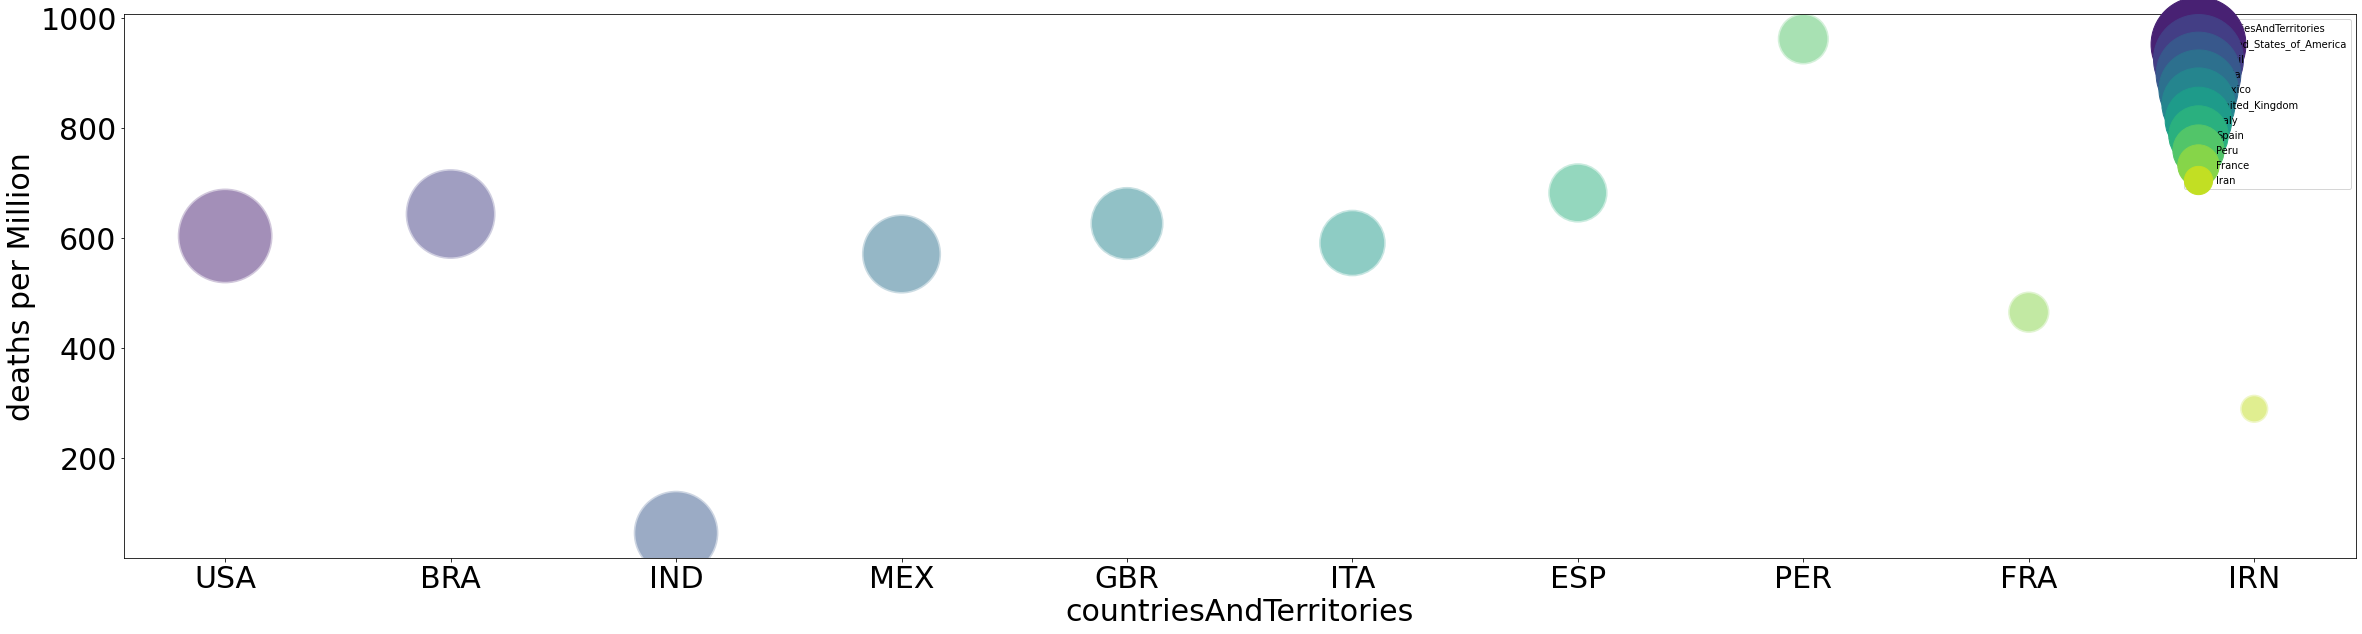

In [31]:
# Scatterplot with deathsPerMil against countriesAndTerritories
fig, ax = plt.subplots(figsize=(40,10))
ax = sns.scatterplot(x = "countryterritoryCode", y = "deathsPerMil", data=df1, size="countriesAndTerritories",hue="countriesAndTerritories",sizes=(800, 9000),alpha=.5, palette="viridis")

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.xlabel('countriesAndTerritories',fontsize=30)  
plt.ylabel('deaths per Million',fontsize=30)
plt.show()

In [32]:
# Min-max and standard Scaling on total cases and total deaths
X = df.iloc[:, 0:2].values
distributions = [
    ('Unscaled data', X),
    ('Data after standard scaling',
        StandardScaler().fit_transform(X)),
    ('Data after min-max scaling',
        MinMaxScaler().fit_transform(X)),
]

y_full = df.iloc[:,4].values
y = minmax_scale(y_full)

In [33]:
# plasma does not exist in matplotlib < 1.5
cmap = getattr(cm, 'viridis_r', cm.hot_r)

In [34]:
def create_axes(title, figsize=(16, 6)):
    fig = plt.figure(figsize=figsize)
    fig.suptitle(title)

    # define the axis for the first plot
    left, width = 0.1, 0.22
    bottom, height = 0.1, 0.7
    bottom_h = height + 0.15
    left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.1]
    rect_histy = [left_h, bottom, 0.05, height]

    ax_scatter = plt.axes(rect_scatter)
    ax_histx = plt.axes(rect_histx)
    ax_histy = plt.axes(rect_histy)

    # define the axis for the zoomed-in plot
    left = width + left + 0.2
    left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.1]
    rect_histy = [left_h, bottom, 0.05, height]

    ax_scatter_zoom = plt.axes(rect_scatter)
    ax_histx_zoom = plt.axes(rect_histx)
    ax_histy_zoom = plt.axes(rect_histy)

    # define the axis for the colorbar
    left, width = width + left + 0.13, 0.01

    rect_colorbar = [left, bottom, width, height]
    ax_colorbar = plt.axes(rect_colorbar)

    return ((ax_scatter, ax_histy, ax_histx),
            (ax_scatter_zoom, ax_histy_zoom, ax_histx_zoom),
            ax_colorbar)


def plot_distribution(axes, X, y, hist_nbins=50, title="",
                      x0_label="", x1_label=""):
    ax, hist_X1, hist_X0 = axes

    ax.set_title(title)
    ax.set_xlabel(x0_label)
    ax.set_ylabel(x1_label)

    # The scatter plot
    colors = cmap(y)
    ax.scatter(X[:, 0], X[:, 1], alpha=0.5, marker='o', s=7, lw=7, c=colors)

    # Removing the top and the right spine for aesthetics
    # make nice axis layout
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))

    # Histogram for axis X1 (feature 5)
    hist_X1.set_ylim(ax.get_ylim())
    hist_X1.hist(X[:, 1], bins=hist_nbins, orientation='horizontal',
                 color='grey', ec='grey')
    hist_X1.axis('off')

    # Histogram for axis X0 (feature 0)
    hist_X0.set_xlim(ax.get_xlim())
    hist_X0.hist(X[:, 0], bins=hist_nbins, orientation='vertical',
                 color='grey', ec='grey')
    hist_X0.axis('off')

In [35]:
def make_plot(item_idx):
    title, X = distributions[item_idx]
    ax_zoom_out, ax_zoom_in, ax_colorbar = create_axes(title)
    axarr = (ax_zoom_out, ax_zoom_in)
    plot_distribution(axarr[0], X, y, hist_nbins=200,
                      x0_label="tot_cases",
                      x1_label="tot_deaths",
                      title="Full data")

    # zoom-in
    zoom_in_percentile_range = (0, 99)
    cutoffs_X0 = np.percentile(X[:, 0], zoom_in_percentile_range)
    cutoffs_X1 = np.percentile(X[:, 1], zoom_in_percentile_range)

    non_outliers_mask = (
        np.all(X > [cutoffs_X0[0], cutoffs_X1[0]], axis=1) &
        np.all(X < [cutoffs_X0[1], cutoffs_X1[1]], axis=1))
    plot_distribution(axarr[1], X[non_outliers_mask], y[non_outliers_mask],
                      hist_nbins=50,
                      x0_label="tot_cases",
                      x1_label="tot_deaths",
                      title="Zoom-in")

    norm = mpl.colors.Normalize(y_full.min(), y_full.max())
    mpl.colorbar.ColorbarBase(ax_colorbar, cmap=cmap,
                              norm=norm, orientation='vertical',
                              label='Color mapping for values of y')

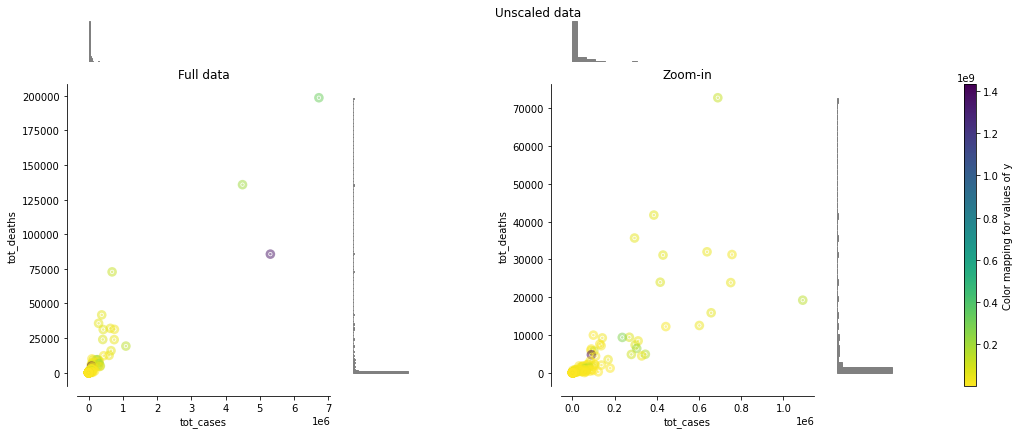

In [36]:
# Distribution plot - unscaled data 
make_plot(0)

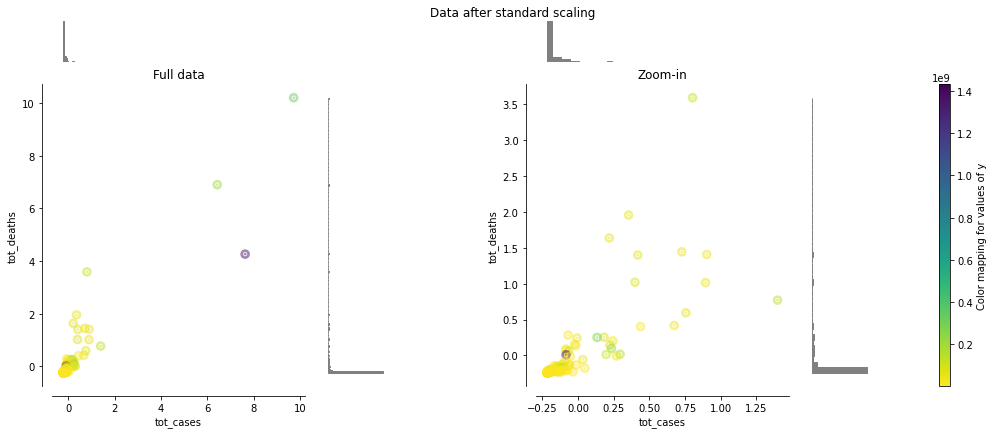

In [37]:
# Distribution plot - standard scaling
make_plot(1)

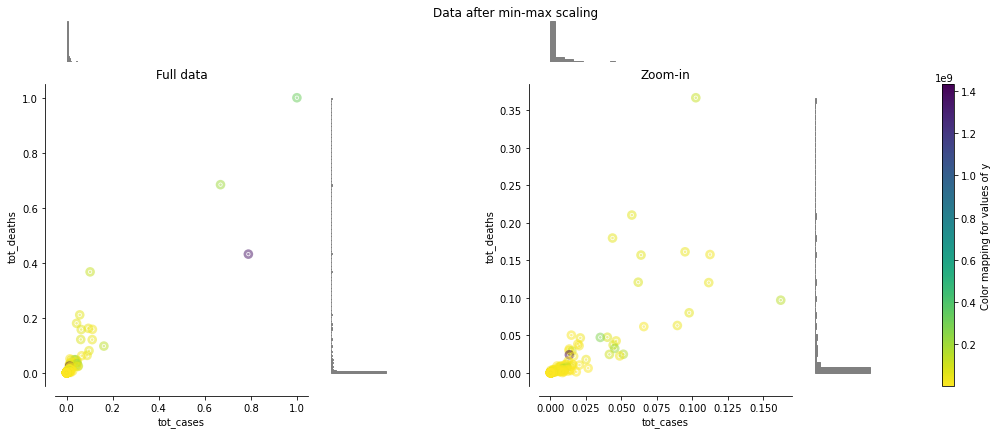

In [38]:
# Distribution plot - MimMax scaling
make_plot(2)